In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras import optimizers, losses, activations, models
from tensorflow.keras.layers import Convolution2D, Dense, Input, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Concatenate
from tensorflow.keras import applications
import numpy as np
import pandas as pd
from tensorflow.keras.applications.inception_v3 import preprocess_input
from keras.models import load_model
import re

In [4]:
df=pd.read_csv('../input/testtask2/test.csv')
print(df)

      Unnamed: 0  Unnamed: 0.1            tweet_id              image_id  \
0          11755         11755  908720732724695040  908720732724695040_1   
1           1157          1157  920916661519007745  920916661519007745_3   
2          16557         16557  910244621367877639  910244621367877639_0   
3           7679          7679  930949813553782785  930949813553782785_0   
4            196           196  917871713823502336  917871713823502336_0   
...          ...           ...                 ...                   ...   
3612        2888          2888  910639429664026624  910639429664026624_2   
3613        8619          8619  904536937431781376  904536937431781376_0   
3614       16509         16509  910236675615358978  910236675615358978_0   
3615        1418          1418  922568378367086593  922568378367086593_0   
3616          91            91  917830092620836864  917830092620836864_1   

            text_info  text_info_conf       image_info  image_info_conf  \
0         in

In [36]:
def OR(op1,op2):
    ans=[]
    for i in range(len(op1)):
        if op1[i]==2 or op2[i]==2:
            ans.append(2)
        elif op1[i]==0 or op2[i]==0:
            ans.append(0)
        else:
            ans.append(1)
    return ans

In [6]:
def resolve(string):
    if string=='humanitarian':
        return 0
    if string=='non_informative':
        return 1
    if string=='structure':
        return 2

**Reading the actual labels**

In [7]:
image_real=[]
text_real=[]
for _,row in df.iterrows():
    image_real.append(resolve(row['image_human_class']))
    text_real.append(resolve(row['text_human_class']))

**Getting the output after Performing OR operation . Damage given higher preference**

In [37]:
multimodal_real=OR(image_real,text_real)

In [9]:

count=[0,0,0]
for i in multimodal_real:
    count[i]+=1
print(count)

[990, 1707, 920]


**image classification**

In [18]:
savemodel = tf.keras.models.load_model('../input/deittask2/deit-task2')

In [19]:
image_predicted=[]
for _,row in df.iterrows():
    path=f'../input/crisismmd/CrisisMMD_v2.0/{row["image_path"]}'
    img = tf.keras.utils.load_img(
    path, target_size=(384,384)
    )
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    img_array=preprocess_input(img_array)

    predictions = savemodel.predict(img_array)
    image_predicted.append(np.argmax(predictions))

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [20]:
from sklearn import metrics
print(metrics.classification_report(image_real,image_predicted))
print(metrics.confusion_matrix(image_real,image_predicted))

              precision    recall  f1-score   support

           0       0.64      0.75      0.69       583
           1       0.92      0.87      0.90      2248
           2       0.81      0.83      0.82       786

    accuracy                           0.84      3617
   macro avg       0.79      0.82      0.80      3617
weighted avg       0.85      0.84      0.85      3617

[[ 439   94   50]
 [ 182 1963  103]
 [  63   73  650]]


In [10]:
def preprocess(text):
  
    text=text.lower()
    text=re.sub(r'rt\s*@[^:]*:\s', ' ', text)
    text=re.sub(r'[^A-Za-z0-9]+', ' ', text)
    text=re.sub(r' t .*$', '', text)
    text=re.sub(r'\b[a-zA-Z]\b', '', text)
    text=re.sub(r'/^\s+|\s+$|\s+(?=\s)/g', '', text);
    text = re.sub(r's+[a-zA-Z]s+', '', text)
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)
    text=re.sub(r'https?','',text)
    text=re.sub(r'#[A-Za-z0-9_]+','',text)
    text=re.sub(r'\.\.\.',' ',text)
    text=text.replace('…',' ')
    text=text.replace('..',' ')
    text=re.sub(r'@\w*',r'',text)
    text=re.sub(r'\s{2,}',r' ',text)
    text=re.sub(r'$[\s]+','',text)
    text=text.replace('&amp','')
    text=text.replace('&gt','')
    text=text.replace('&lt','')
    text=re.sub(r'([\w\d]+)([^\w\d ]+)', r'\1 \2',text)
    text=re.sub(r'([^\w\d ]+)([\w\d]+)', r'\1 \2',text)

    return text
df["tweet_text"]=df["tweet_text"].apply(lambda x: preprocess(x))
df["type"] = df["text_human_class"].apply(lambda x: 0 if x == "humanitarian" else 1 if x == "non_informative" else 2)

df

,Unnamed: 0,Unnamed: 0.1,tweet_id,image_id,text_info,text_info_conf,image_info,image_info_conf,text_human,text_human_conf,image_human,image_human_conf,image_damage,image_damage_conf,tweet_text,image_url,image_path,image_human_class,text_human_class,type
0,11755,11755,908720732724695040,908720732724695040_1,informative,0.6815,not_informative,0.6491,rescue_volunteering_or_donation_effort,0.6815,not_humanitarian,0.6491,NaN,NaN,selling popcorn at lunch to benefit victims of...,http://pbs.twimg.com/media/DJxspzRVYAAug-0.jpg,data_image/hurricane_harvey/15_9_2017/90872073...,non_informative,humanitarian,0
1,1157,1157,920916661519007745,920916661519007745_3,informative,0.6716,informative,0.6725,other_relevant_information,0.6716,infrastructure_and_utility_damage,0.6725,severe_damage,1.0000,not only california northern spain amp portuga...,http://pbs.twimg.com/media/DMe4n-_W4AA5mmJ.jpg,data_image/california_wildfires/19_10_2017/920...,structure,non_informative,1
2,16557,16557,910244621367877639,910244621367877639_0,informative,1.0000,informative,1.0000,other_relevant_information,1.0000,other_relevant_information,1.0000,NaN,NaN,5pm tuesday tropical update maria still catego...,http://pbs.twimg.com/media/DKHWqFhXUAAsZ31.jpg,data_image/hurricane_irma/19_9_2017/9102446213...,non_informative,non_informative,1
3,7679,7679,930949813553782785,930949813553782785_0,not_informative,0.6181,not_informative,1.0000,not_humanitarian,0.6181,not_humanitarian,1.0000,NaN,NaN,3 scenes of landsat ingested to hdds for event...,http://pbs.twimg.com/media/DOtl693X0AA6zPN.jpg,data_image/iraq_iran_earthquake/16_11_2017/930...,non_informative,non_informative,1
4,196,196,917871713823502336,917871713823502336_0,not_informative,0.6449,informative,0.7607,not_humanitarian,0.6449,infrastructure_and_utility_damage,0.7607,severe_damage,0.7206,realomarnavarro schnauzermom777 can you stop ...,http://pbs.twimg.com/media/DLzvc-5V4AACico.jpg,data_image/california_wildfires/10_10_2017/917...,structure,non_informative,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3612,2888,2888,910639429664026624,910639429664026624_2,informative,0.6389,informative,1.0000,other_relevant_information,0.6389,infrastructure_and_utility_damage,1.0000,severe_damage,1.0000,my town in pr after hurricane maria,http://pbs.twimg.com/media/DKM9ugfW4AIXiOm.jpg,data_image/hurricane_maria/20_9_2017/910639429...,structure,non_informative,1
3613,8619,8619,904536937431781376,904536937431781376_0,not_informative,0.7122,not_informative,1.0000,not_humanitarian,0.7122,not_humanitarian,1.0000,NaN,NaN,stiletto in texas it more than shoe it an att...,http://pbs.twimg.com/media/DIurGHxVAAAWu_J.jpg,data_image/hurricane_harvey/4_9_2017/904536937...,non_informative,non_informative,1
3614,16509,16509,910236675615358978,910236675615358978_0,informative,1.0000,not_informative,1.0000,rescue_volunteering_or_donation_effort,1.0000,not_humanitarian,1.0000,NaN,NaN,help our members affected by harvey and irma d...,http://pbs.twimg.com/media/DKHPbVAUEAEfz5R.jpg,data_image/hurricane_irma/19_9_2017/9102366756...,non_informative,humanitarian,0
3615,1418,1418,922568378367086593,922568378367086593_0,informative,0.6467,informative,0.7077,other_relevant_information,0.6467,infrastructure_and_utility_damage,0.7077,severe_damage,1.0000,california wine country wildfires near contain...,http://pbs.twimg.com/media/DM2fDFFVAAE4u1e.jpg,data_image/california_wildfires/23_10_2017/922...,structure,non_informative,1


In [11]:
from transformers import AlbertTokenizer, TFAlbertModel
tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')
albert = TFAlbertModel.from_pretrained('albert-base-v2', output_hidden_states = True)

2022-06-04 22:19:05.110277: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-04 22:19:05.111423: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-04 22:19:05.112171: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-04 22:19:05.113126: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [12]:
tokenized_test = df["tweet_text"].apply((lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=60)))
max_len=60
input_ids_test= np.array([i + [0]*(max_len-len(i)) for i in tokenized_test.values])
attention_mask_test=np.where(input_ids_test!= 0, 1, 0)
arr_test = df["type"].values

num_samples_test = len(df)

labels_test = np.zeros((num_samples_test, arr_test.max()+1))

labels_test[np.arange(num_samples_test), arr_test] = 1

dataset_test = tf.data.Dataset.from_tensor_slices((input_ids_test,attention_mask_test,labels_test))

def map_func(input_ids, masks, labels):
    return {'input_ids' : input_ids, 'attention_mask' : masks}, labels

dataset_test = dataset_test.map(map_func)
dataset_test = dataset_test.batch(8)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [13]:
from keras.models import load_model

saved_model =load_model('../input/alberttask2/best_model_Albert_task2-lastlayergooddecay.h5', custom_objects={"TFAlbertModel": albert})
saved_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 60)]         0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 60)]         0                                            
__________________________________________________________________________________________________
tf_albert_model_1 (TFAlbertMode TFBaseModelOutputWit 11683584    input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
lstm_4 (LSTM)                   (None, 60, 128)      459264      tf_albert_model_1[0][13]   

In [14]:
temp=[]
for inputs_id_mask_batch, class_batch in dataset_test:   
    preds = saved_model.predict(inputs_id_mask_batch)
    temp.append(np.argmax(preds, axis = - 1))

text_predicted = tf.concat([item for item in temp], axis = 0)

2022-06-04 22:19:18.367297: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-06-04 22:19:22.638260: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


In [15]:
from sklearn import metrics
print(metrics.classification_report(text_real,text_predicted))
print(metrics.confusion_matrix(text_real,text_predicted))

              precision    recall  f1-score   support

           0       0.79      0.81      0.80       958
           1       0.91      0.84      0.88      2367
           2       0.51      0.77      0.61       292

    accuracy                           0.83      3617
   macro avg       0.74      0.81      0.76      3617
weighted avg       0.85      0.83      0.83      3617

[[ 775  142   41]
 [ 194 1997  176]
 [   9   58  225]]


In [21]:
multimodal_predicted=OR(text_predicted,image_predicted)

In [39]:
from sklearn import metrics
print(metrics.classification_report(multimodal_real,multimodal_predicted))
print(metrics.confusion_matrix(multimodal_real,multimodal_predicted))

              precision    recall  f1-score   support

           0       0.74      0.81      0.77       990
           1       0.90      0.79      0.84      1707
           2       0.75      0.85      0.80       920

    accuracy                           0.81      3617
   macro avg       0.80      0.82      0.80      3617
weighted avg       0.82      0.81      0.81      3617

[[ 801   88  101]
 [ 209 1341  157]
 [  79   58  783]]


In [38]:
def r(n):
    if n==0:
        return 'Humanitarian'
    if n==1:
        return 'non info'
    return 'damage'

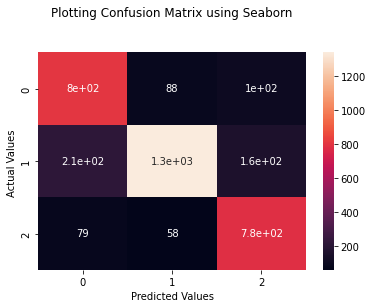

In [23]:
import seaborn as sebrn
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as atlas

conf_matrix = (confusion_matrix(multimodal_real, multimodal_predicted))

# Using Seaborn heatmap to create the plot
fx = sebrn.heatmap(conf_matrix, annot=True)

# labels the title and x, y axis of plot
fx.set_title('Plotting Confusion Matrix using Seaborn\n\n');
fx.set_xlabel('Predicted Values')
fx.set_ylabel('Actual Values ');